In [2]:
# Загружаем датасет рукописных английских букв emnist
# Каждая буква представлена в формате картинки 28х28 пикселей
import kagglehub

path = kagglehub.dataset_download("crawford/emnist")

print("Path to dataset files:", path)

Path to dataset files: C:\Users\fdsaf\.cache\kagglehub\datasets\crawford\emnist\versions\3


In [3]:
# Необходимо взять emnist-letters-test.csv и emnist-letters-train.csv
# Каждая строка в таблице - отдельная картинка
# 785 (28 x 28) столбцов, каждый столбец = величина пикселя 
# Первый столбец — это метка класса (какая это буква). Подробнее в mappings.txt
import pandas as pd # для обработки данных
testing_letter = pd.read_csv(path + '/emnist-letters-test.csv')
training_letter = pd.read_csv(path + '/emnist-letters-train.csv')

print(training_letter.shape) # 88799 = количество элементов для обучения
print(testing_letter.shape) # 14799 = кол-во элементов для тестирования

(88799, 785)
(14799, 785)


(88799,)
(88799, 784)


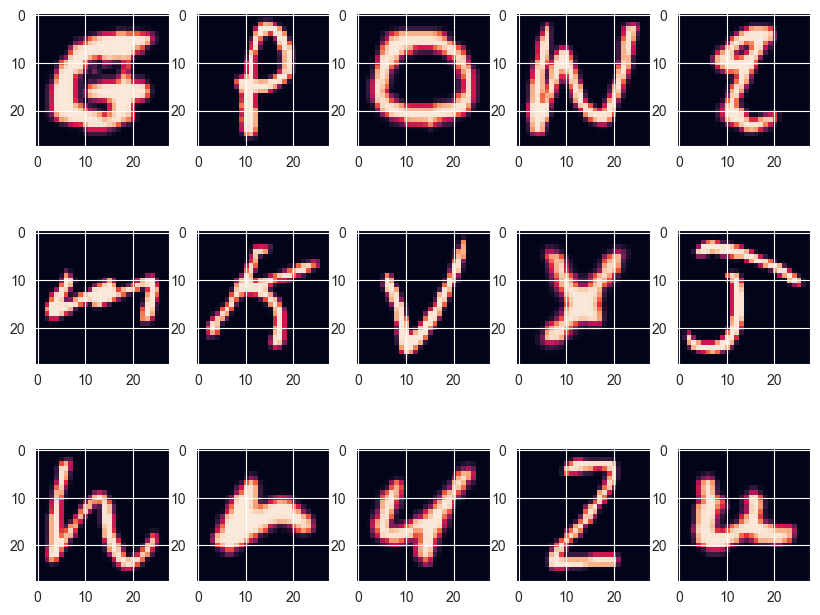

In [4]:
import numpy as np # для линейной алгебры
# training_letter
y1 = np.array(training_letter.iloc[:,0].values) # Берём первый столбец всех строк (метка класса)
x1 = np.array(training_letter.iloc[:,1:].values) # Все строки, все столбцы кроме первого столбца
# testing_letter
y2 = np.array(testing_letter.iloc[:,0].values)
x2 = np.array(testing_letter.iloc[:,1:].values)
print(y1.shape) # метки для обучающей выборки
print(x1.shape) # признаки обучающей выборки


# Проверка картинок
import matplotlib.pyplot as plt # для создания графиков
fig,axes = plt.subplots(3,5,figsize=(10,8)) # создаёт сетку 3х5 из графиков, каждая клетка размером 10х8
for i,ax in enumerate(axes.flat): # индекс, объект оси
    ax.imshow(x1[i].reshape([28,28]).T) # отображает изображение, нужно транспонировать

In [5]:
# Перед тем, как подавать в данные в модель, мы нормализуем и изменим предоставленные нам данные. Это уменьшит сложность моделей и сделает модель эффективно работать, так как для обработки будут менее сложные числа.

# Приводим данные к диапазону [0,1]
train_images = x1 / 255.0
test_images = x2 / 255.0

train_images_number = train_images.shape[0] # кол-во изображений в обучающей выборке
train_images_height = 28
train_images_width = 28
train_images_size = train_images_height*train_images_width

train_images = train_images.reshape(train_images_number, train_images_height, train_images_width, 1)
# кол-во изображений, высота, ширина, 1 = кол-во каналов (1 т.к. чёрно белое)

test_images_number = test_images.shape[0]
test_images_height = 28
test_images_width = 28
test_images_size = test_images_height*test_images_width

test_images = test_images.reshape(test_images_number, test_images_height, test_images_width, 1)

In [6]:
import tensorflow as tf

# Количество классов (26 букв английского алфавита + спец символы)
number_of_classes = 37

# Преобразует метки классов в one-hot encoding.
# Например Если y1[i] = 2, то one-hot encoding будет [0, 0, 1, 0, ..., 0] 
# (длина вектора равна number_of_classes).
y1 = tf.keras.utils.to_categorical(y1, number_of_classes)
y2 = tf.keras.utils.to_categorical(y2, number_of_classes)

In [7]:
# Функция из библиотеки scikit-learn, которая разделяет данные на обучающую и тестовую выборки.
from sklearn.model_selection import train_test_split

# Делим данные на две части: обучающая выборка (80% данных), валидационная выборка (20% данных). 
# Фиксируем случайное разбиение для воспроизводимости результатов (random_state = 42)
train_x,test_x,train_y,test_y = train_test_split(train_images,y1,test_size=0.2,random_state = 42)

# Создание сверточной НС. Эта модель является FFNN, так как она соответствует определению сети прямого распространения.
# 1. Сверточный слой (Conv2D): 32 фильтра размером 3x3. Размер входных данных (28x28 пикселей, 1 канал)
# 2. Слой подвыборки (MaxPooling2D): Уменьшает размерность данных, выбирая макс значение в окне 2x2
# 3. Слой выравнивания (Flatten): Преобразует двумерные данные в одномерный вектор.
# 4. Полносвязные слои (Dense): Слой с 512 и 128 нейронами и функцией активации ReLU.
# 5. Выходной слой (Dense): Слой с количеством нейронов, равным числу классов (37), и функцией активации softmax
def configure_model(activation='relu', hidden_units=128):
    model = tf.keras.Sequential([
        tf.keras.layers.Flatten(input_shape=(28, 28, 1)),
        tf.keras.layers.Dense(512, activation=activation),
        tf.keras.layers.Dense(hidden_units, activation=activation),
        tf.keras.layers.Dense(number_of_classes, activation='softmax')
    ])
    return model

model = configure_model()

C:\Users\fdsaf\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [8]:
def compile_model(model, epochs=10):
    # Модель настраивается для обучения.
    # optimizer='rmsprop': Используется оптимизатор RMSprop для обновления весов модели.
    # loss='categorical_crossentropy': Функция потерь для многоклассовой классификации
    # metrics=['accuracy']: Метрика, которая будет отслеживаться во время обучения (точность).
    model.compile(optimizer='rmsprop',loss='categorical_crossentropy',metrics=['accuracy'])

    from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
    # EarlyStopping, ReduceLROnPlateau, ModelCheckpoint:
    # Это callback-функции, которые используются для улучшения процесса обучения модели.
    # EarlyStopping: Останавливает обучение, если метрика (например, точность) перестает улучшаться.
    # ReduceLROnPlateau: Уменьшает скорость обучения, если метрика перестает улучшаться.
    # ModelCheckpoint: Сохраняет лучшую версию модели во время обучения.

    MCP = ModelCheckpoint('Best_points.h5',verbose=1,save_best_only=True,monitor='val_accuracy',mode='max')
    ES = EarlyStopping(monitor='val_accuracy',min_delta=0,verbose=0,restore_best_weights = True,patience=3,mode='max')
    RLP = ReduceLROnPlateau(monitor='val_loss',patience=3,factor=0.2,min_lr=0.0001)

    # объект, который содержит информацию о процессе обучения (например, значения потерь и точности на каждой эпохе).
    history = model.fit(train_x,train_y,epochs=epochs,validation_data=(test_x,test_y),callbacks=[MCP,ES,RLP])
    return history
history = compile_model(model)

Epoch 1/10
2208/2220 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6955 - loss: 1.0274
Epoch 1: val_accuracy improved from -inf to 0.85749, saving model to Best_points.h5


2220/2220 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.6961 - loss: 1.0253 - val_accuracy: 0.8575 - val_loss: 0.4329 - learning_rate: 0.0010
Epoch 2/10
2206/2220 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8805 - loss: 0.3726
Epoch 2: val_accuracy improved from 0.85749 to 0.88159, saving model to Best_points.h5


2220/2220 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.8805 - loss: 0.3726 - val_accuracy: 0.8816 - val_loss: 0.3783 - learning_rate: 0.0010
Epoch 3/10
2195/2220 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9043 - loss: 0.2980
Epoch 3: val_accuracy did not improve from 0.88159
2220/2220 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9042 - loss: 0.2981 - val_accuracy: 0.8792 - val_loss: 0.4021 - learning_rate: 0.0010
Epoch 4/10
2213/2220 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9143 - loss: 0.2666
Epoch 4: val_accuracy improved from 0.88159 to 0.88221, saving model to Best_points.h5


2220/2220 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9143 - loss: 0.2667 - val_accuracy: 0.8822 - val_loss: 0.4248 - learning_rate: 0.0010
Epoch 5/10
2218/2220 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9224 - loss: 0.2484
Epoch 5: val_accuracy improved from 0.88221 to 0.88688, saving model to Best_points.h5


2220/2220 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9224 - loss: 0.2484 - val_accuracy: 0.8869 - val_loss: 0.4070 - learning_rate: 0.0010
Epoch 6/10
2209/2220 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9473 - loss: 0.1568
Epoch 6: val_accuracy improved from 0.88688 to 0.90850, saving model to Best_points.h5


2220/2220 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9473 - loss: 0.1568 - val_accuracy: 0.9085 - val_loss: 0.3499 - learning_rate: 2.0000e-04
Epoch 7/10
2219/2220 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9580 - loss: 0.1240
Epoch 7: val_accuracy did not improve from 0.90850
2220/2220 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9580 - loss: 0.1240 - val_accuracy: 0.9082 - val_loss: 0.3793 - learning_rate: 2.0000e-04
Epoch 8/10
2193/2220 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9610 - loss: 0.1198
Epoch 8: val_accuracy did not improve from 0.90850
2220/2220 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9610 - loss: 0.1198 - val_accuracy: 0.9075 - val_loss: 0.3885 - learning_rate: 2.0000e-04
Epoch 9/10
2214/2220 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9634 - loss: 0.1071
Epoch 9: val_accuracy improved from 0.90850 to 0.90912, saving model to Best_points.h5


2220/2220 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9634 - loss: 0.1071 - val_accuracy: 0.9091 - val_loss: 0.3800 - learning_rate: 2.0000e-04
Epoch 10/10
2189/2220 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9696 - loss: 0.0918
Epoch 10: val_accuracy improved from 0.90912 to 0.90923, saving model to Best_points.h5


2220/2220 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9696 - loss: 0.0918 - val_accuracy: 0.9092 - val_loss: 0.3871 - learning_rate: 1.0000e-04


Text(0, 0.5, 'Accuray')

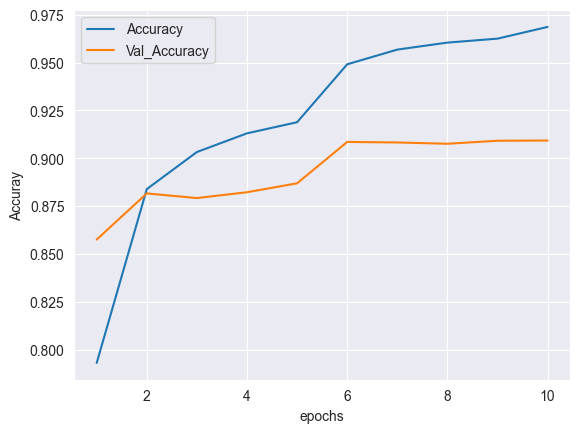

In [9]:
# для создания статистических графиков.
import seaborn as sns

# Получаем количество эпох, на которых обучалась модель
# history.history['accuracy'] содержит значения точности на обучающих данных для каждой эпохи
q = len(history.history['accuracy'])

# Устанавливаем размер графика (10x10 дюймов)
plt.figsize=(10,10)

# Строим график точности на обучающих данных (accuracy)
# x = range(1, 1+q): ось X — это номера эпох (начиная с 1)
# y = history.history['accuracy']: ось Y — значения точности на обучающих данных
# label='Accuracy': подпись для графика
sns.lineplot(x = range(1,1+q),y = history.history['accuracy'], label='Accuracy')
sns.lineplot(x = range(1,1+q),y = history.history['val_accuracy'], label='Val_Accuracy')
plt.xlabel('epochs')
plt.ylabel('Accuray')

C:\Users\fdsaf\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2192/2220 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1550 - loss: 2.8338
Epoch 1: val_accuracy improved from -inf to 0.30873, saving model to Best_points.h5


2220/2220 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.1558 - loss: 2.8292 - val_accuracy: 0.3087 - val_loss: 2.1294 - learning_rate: 0.0010
2213/2220 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.2895 - loss: 2.4699
Epoch 1: val_accuracy improved from -inf to 0.66712, saving model to Best_points.h5


2220/2220 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.2901 - loss: 2.4676 - val_accuracy: 0.6671 - val_loss: 1.1755 - learning_rate: 0.0010
2201/2220 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4910 - loss: 1.8345
Epoch 1: val_accuracy improved from -inf to 0.80321, saving model to Best_points.h5


2220/2220 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.4926 - loss: 1.8286 - val_accuracy: 0.8032 - val_loss: 0.6618 - learning_rate: 0.0010
2190/2220 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5840 - loss: 1.4990
Epoch 1: val_accuracy improved from -inf to 0.81926, saving model to Best_points.h5


2220/2220 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.5860 - loss: 1.4914 - val_accuracy: 0.8193 - val_loss: 0.5989 - learning_rate: 0.0010
2203/2220 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6474 - loss: 1.2383
Epoch 1: val_accuracy improved from -inf to 0.85315, saving model to Best_points.h5


2220/2220 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.6484 - loss: 1.2348 - val_accuracy: 0.8532 - val_loss: 0.4795 - learning_rate: 0.0010
2196/2220 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6882 - loss: 1.0700
Epoch 1: val_accuracy improved from -inf to 0.85236, saving model to Best_points.h5


2220/2220 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.6893 - loss: 1.0659 - val_accuracy: 0.8524 - val_loss: 0.4643 - learning_rate: 0.0010
2187/2220 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7037 - loss: 1.0023
Epoch 1: val_accuracy improved from -inf to 0.84578, saving model to Best_points.h5


2220/2220 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.7051 - loss: 0.9971 - val_accuracy: 0.8458 - val_loss: 0.4852 - learning_rate: 0.0010
2200/2220 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7097 - loss: 0.9686
Epoch 1: val_accuracy improved from -inf to 0.86593, saving model to Best_points.h5


2220/2220 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.7106 - loss: 0.9656 - val_accuracy: 0.8659 - val_loss: 0.4323 - learning_rate: 0.0010
2205/2220 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7163 - loss: 0.9490
Epoch 1: val_accuracy improved from -inf to 0.85574, saving model to Best_points.h5


2220/2220 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.7169 - loss: 0.9467 - val_accuracy: 0.8557 - val_loss: 0.4446 - learning_rate: 0.0010
2206/2220 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7218 - loss: 0.9160
Epoch 1: val_accuracy improved from -inf to 0.86042, saving model to Best_points.h5


2220/2220 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.7224 - loss: 0.9140 - val_accuracy: 0.8604 - val_loss: 0.4582 - learning_rate: 0.0010
2218/2220 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7265 - loss: 0.9026
Epoch 1: val_accuracy improved from -inf to 0.87382, saving model to Best_points.h5


2220/2220 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - accuracy: 0.7266 - loss: 0.9022 - val_accuracy: 0.8738 - val_loss: 0.4158 - learning_rate: 0.0010
2215/2220 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7287 - loss: 0.9004
Epoch 1: val_accuracy improved from -inf to 0.87506, saving model to Best_points.h5


2220/2220 ━━━━━━━━━━━━━━━━━━━━ 20s 9ms/step - accuracy: 0.7289 - loss: 0.8996 - val_accuracy: 0.8751 - val_loss: 0.3983 - learning_rate: 0.0010
2220/2220 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.7224 - loss: 0.9161
Epoch 1: val_accuracy improved from -inf to 0.85411, saving model to Best_points.h5


2220/2220 ━━━━━━━━━━━━━━━━━━━━ 42s 19ms/step - accuracy: 0.7224 - loss: 0.9159 - val_accuracy: 0.8541 - val_loss: 0.4646 - learning_rate: 0.0010
2219/2220 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.7208 - loss: 0.9287
Epoch 1: val_accuracy improved from -inf to 0.86053, saving model to Best_points.h5


2220/2220 ━━━━━━━━━━━━━━━━━━━━ 80s 36ms/step - accuracy: 0.7209 - loss: 0.9284 - val_accuracy: 0.8605 - val_loss: 0.4519 - learning_rate: 0.0010
2220/2220 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 0.7158 - loss: 0.9468
Epoch 1: val_accuracy improved from -inf to 0.85372, saving model to Best_points.h5


2220/2220 ━━━━━━━━━━━━━━━━━━━━ 182s 82ms/step - accuracy: 0.7158 - loss: 0.9466 - val_accuracy: 0.8537 - val_loss: 0.4564 - learning_rate: 0.0010


C:\Users\fdsaf\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2207/2220 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0828 - loss: 3.2795
Epoch 1: val_accuracy improved from -inf to 0.12303, saving model to Best_points.h5


2220/2220 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.0829 - loss: 3.2784 - val_accuracy: 0.1230 - val_loss: 2.9192 - learning_rate: 0.0010
2212/2220 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1595 - loss: 3.1259
Epoch 1: val_accuracy improved from -inf to 0.28271, saving model to Best_points.h5


2220/2220 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.1597 - loss: 3.1249 - val_accuracy: 0.2827 - val_loss: 2.5292 - learning_rate: 0.0010
2201/2220 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.2373 - loss: 2.9031
Epoch 1: val_accuracy improved from -inf to 0.51931, saving model to Best_points.h5


2220/2220 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.2383 - loss: 2.8996 - val_accuracy: 0.5193 - val_loss: 1.9009 - learning_rate: 0.0010
2203/2220 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3645 - loss: 2.5549
Epoch 1: val_accuracy improved from -inf to 0.67753, saving model to Best_points.h5


2220/2220 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.3656 - loss: 2.5504 - val_accuracy: 0.6775 - val_loss: 1.2684 - learning_rate: 0.0010
2212/2220 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4631 - loss: 2.1624
Epoch 1: val_accuracy improved from -inf to 0.73677, saving model to Best_points.h5


2220/2220 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.4637 - loss: 2.1599 - val_accuracy: 0.7368 - val_loss: 0.9210 - learning_rate: 0.0010
2197/2220 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5079 - loss: 1.9086
Epoch 1: val_accuracy improved from -inf to 0.77461, saving model to Best_points.h5


2220/2220 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.5094 - loss: 1.9023 - val_accuracy: 0.7746 - val_loss: 0.7685 - learning_rate: 0.0010
2189/2220 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5324 - loss: 1.7052
Epoch 1: val_accuracy improved from -inf to 0.80152, saving model to Best_points.h5


2220/2220 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.5344 - loss: 1.6973 - val_accuracy: 0.8015 - val_loss: 0.6719 - learning_rate: 0.0010
2194/2220 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5417 - loss: 1.6009
Epoch 1: val_accuracy improved from -inf to 0.80867, saving model to Best_points.h5


2220/2220 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.5434 - loss: 1.5946 - val_accuracy: 0.8087 - val_loss: 0.6336 - learning_rate: 0.0010
2204/2220 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5412 - loss: 1.5642
Epoch 1: val_accuracy improved from -inf to 0.81627, saving model to Best_points.h5


2220/2220 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.5423 - loss: 1.5601 - val_accuracy: 0.8163 - val_loss: 0.5947 - learning_rate: 0.0010
2217/2220 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5359 - loss: 1.5644
Epoch 1: val_accuracy improved from -inf to 0.81329, saving model to Best_points.h5


2220/2220 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.5361 - loss: 1.5634 - val_accuracy: 0.8133 - val_loss: 0.6020 - learning_rate: 0.0010
2212/2220 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5205 - loss: 1.6413
Epoch 1: val_accuracy improved from -inf to 0.80411, saving model to Best_points.h5


2220/2220 ━━━━━━━━━━━━━━━━━━━━ 12s 5ms/step - accuracy: 0.5211 - loss: 1.6390 - val_accuracy: 0.8041 - val_loss: 0.6279 - learning_rate: 0.0010
2217/2220 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.4910 - loss: 1.8428
Epoch 1: val_accuracy improved from -inf to 0.80400, saving model to Best_points.h5


2220/2220 ━━━━━━━━━━━━━━━━━━━━ 22s 10ms/step - accuracy: 0.4913 - loss: 1.8416 - val_accuracy: 0.8040 - val_loss: 0.6240 - learning_rate: 0.0010
2220/2220 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.3522 - loss: 2.5015
Epoch 1: val_accuracy improved from -inf to 0.76109, saving model to Best_points.h5


2220/2220 ━━━━━━━━━━━━━━━━━━━━ 44s 20ms/step - accuracy: 0.3523 - loss: 2.5011 - val_accuracy: 0.7611 - val_loss: 0.7845 - learning_rate: 0.0010
2219/2220 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.1936 - loss: 3.3174
Epoch 1: val_accuracy improved from -inf to 0.68733, saving model to Best_points.h5


2220/2220 ━━━━━━━━━━━━━━━━━━━━ 86s 38ms/step - accuracy: 0.1938 - loss: 3.3163 - val_accuracy: 0.6873 - val_loss: 1.0221 - learning_rate: 0.0010
2220/2220 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 0.1286 - loss: 3.9711
Epoch 1: val_accuracy improved from -inf to 0.60597, saving model to Best_points.h5


2220/2220 ━━━━━━━━━━━━━━━━━━━━ 189s 85ms/step - accuracy: 0.1287 - loss: 3.9704 - val_accuracy: 0.6060 - val_loss: 1.2744 - learning_rate: 0.0010


C:\Users\fdsaf\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2217/2220 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1181 - loss: 3.1434
Epoch 1: val_accuracy improved from -inf to 0.14690, saving model to Best_points.h5


2220/2220 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.1181 - loss: 3.1429 - val_accuracy: 0.1469 - val_loss: 2.5815 - learning_rate: 0.0010
2207/2220 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.2666 - loss: 2.7812
Epoch 1: val_accuracy improved from -inf to 0.41605, saving model to Best_points.h5


2220/2220 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.2670 - loss: 2.7785 - val_accuracy: 0.4160 - val_loss: 1.8122 - learning_rate: 0.0010
2207/2220 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3827 - loss: 2.3809
Epoch 1: val_accuracy improved from -inf to 0.70918, saving model to Best_points.h5


2220/2220 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.3836 - loss: 2.3774 - val_accuracy: 0.7092 - val_loss: 1.1092 - learning_rate: 0.0010
2205/2220 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5343 - loss: 1.8525
Epoch 1: val_accuracy improved from -inf to 0.79859, saving model to Best_points.h5


2220/2220 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.5353 - loss: 1.8485 - val_accuracy: 0.7986 - val_loss: 0.7206 - learning_rate: 0.0010
2183/2220 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6122 - loss: 1.4839
Epoch 1: val_accuracy improved from -inf to 0.82168, saving model to Best_points.h5


2220/2220 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.6141 - loss: 1.4761 - val_accuracy: 0.8217 - val_loss: 0.6033 - learning_rate: 0.0010
2195/2220 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6571 - loss: 1.2344
Epoch 1: val_accuracy improved from -inf to 0.83829, saving model to Best_points.h5


2220/2220 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.6582 - loss: 1.2302 - val_accuracy: 0.8383 - val_loss: 0.5458 - learning_rate: 0.0010
2208/2220 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6834 - loss: 1.0950
Epoch 1: val_accuracy improved from -inf to 0.83485, saving model to Best_points.h5


2220/2220 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.6839 - loss: 1.0932 - val_accuracy: 0.8349 - val_loss: 0.5359 - learning_rate: 0.0010
2212/2220 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6908 - loss: 1.0610
Epoch 1: val_accuracy improved from -inf to 0.84803, saving model to Best_points.h5


2220/2220 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.6911 - loss: 1.0597 - val_accuracy: 0.8480 - val_loss: 0.4983 - learning_rate: 0.0010
2211/2220 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6751 - loss: 1.1052
Epoch 1: val_accuracy improved from -inf to 0.84313, saving model to Best_points.h5


2220/2220 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.6755 - loss: 1.1036 - val_accuracy: 0.8431 - val_loss: 0.4984 - learning_rate: 0.0010
2206/2220 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6457 - loss: 1.2162
Epoch 1: val_accuracy improved from -inf to 0.83187, saving model to Best_points.h5


2220/2220 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.6463 - loss: 1.2137 - val_accuracy: 0.8319 - val_loss: 0.5347 - learning_rate: 0.0010
2209/2220 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6072 - loss: 1.3889
Epoch 1: val_accuracy improved from -inf to 0.81796, saving model to Best_points.h5


2220/2220 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - accuracy: 0.6078 - loss: 1.3867 - val_accuracy: 0.8180 - val_loss: 0.5749 - learning_rate: 0.0010
2219/2220 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5691 - loss: 1.5690
Epoch 1: val_accuracy improved from -inf to 0.80096, saving model to Best_points.h5


2220/2220 ━━━━━━━━━━━━━━━━━━━━ 21s 9ms/step - accuracy: 0.5692 - loss: 1.5686 - val_accuracy: 0.8010 - val_loss: 0.6500 - learning_rate: 0.0010
2219/2220 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.5437 - loss: 1.7488
Epoch 1: val_accuracy improved from -inf to 0.76532, saving model to Best_points.h5


2220/2220 ━━━━━━━━━━━━━━━━━━━━ 42s 19ms/step - accuracy: 0.5438 - loss: 1.7483 - val_accuracy: 0.7653 - val_loss: 0.7940 - learning_rate: 0.0010
2219/2220 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.5125 - loss: 1.9373
Epoch 1: val_accuracy improved from -inf to 0.77393, saving model to Best_points.h5


2220/2220 ━━━━━━━━━━━━━━━━━━━━ 86s 38ms/step - accuracy: 0.5126 - loss: 1.9368 - val_accuracy: 0.7739 - val_loss: 0.7805 - learning_rate: 0.0010
2220/2220 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.4800 - loss: 2.2906
Epoch 1: val_accuracy improved from -inf to 0.71926, saving model to Best_points.h5


2220/2220 ━━━━━━━━━━━━━━━━━━━━ 167s 75ms/step - accuracy: 0.4800 - loss: 2.2903 - val_accuracy: 0.7193 - val_loss: 1.0467 - learning_rate: 0.0010


Text(0.5, 1.0, 'Зависимость val_accuracy от hidden_units и activation')

<Figure size 1000x1000 with 0 Axes>

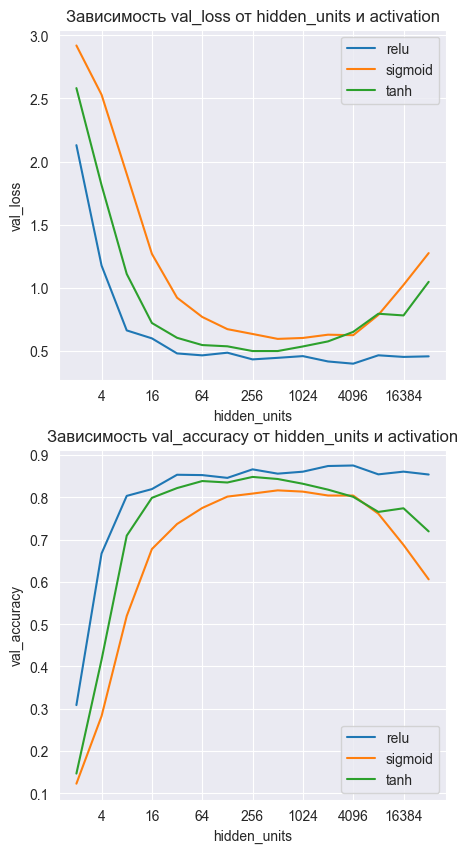

In [14]:
from matplotlib import ticker

# Устанавливаем размер графика (10x10 дюймов)
plt.figure(figsize=(10, 10))

# Создаем два подграфика: один для val_loss, другой для val_accuracy
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(5, 10))

activations = ['relu', 'sigmoid', 'tanh']
neurons_count = [i for i in range(1, 16)] # от 2 до 32768 нейронов
for idx, activation in enumerate(activations):
    val_losses = []
    val_accuracies = []
    for i in neurons_count:
        model = configure_model(activation, 2**i)
        history = compile_model(model, 1)
        val_losses.append(history.history['val_loss'][-1])
        val_accuracies.append(history.history['val_accuracy'][-1])
    sns.lineplot(x = [2**i for i in neurons_count],y = val_losses, label=activation, ax=ax1)
    sns.lineplot(x=[2**i for i in neurons_count], y=val_accuracies, label=activation, ax=ax2)
    
ax1.set_xlabel('hidden_units')
ax1.set_ylabel('val_loss')
ax1.set_xscale('log', base=2)  # Логарифмический масштаб по основанию 2
ax1.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{int(x)}'))  # Отображаем целые числа
ax1.set_title('Зависимость val_loss от hidden_units и activation')


ax2.set_xlabel('hidden_units')
ax2.set_ylabel('val_accuracy')
ax2.set_xscale('log', base=2)  # Логарифмический масштаб по основанию 2
ax2.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{int(x)}'))  # Отображаем целые числа
ax2.set_title('Зависимость val_accuracy от hidden_units и activation')